In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates

# User inputs

In [17]:
DATE = "2020-04-20"
FIPS = 37155
GAMMA = 1/7
MAX_GROWTH_RATE = 1
GR_EWMA_ALPHA = 1 / 10
RT_EWMA_ALPHA = 1 / 3

# Injected inputs

In [18]:
# Parameters
FIPS = 37155

# Constants

In [19]:
TODAY = pd.Timestamp.today().date()

In [20]:
INPUT_FILE_NAME = f"{TODAY}_{FIPS}_betas.csv"
OUTPUT_FILE_NAME = f"{TODAY}_{FIPS}_random-sir-model-output.csv"

# Read in and process USA FACTS data

In [26]:
case_df = pd.read_csv(
    "https://usafactsstatic.blob.core.windows.net/"
    "public/data/covid-19/covid_confirmed_usafacts.csv",
)

case_df = case_df[case_df["countyFIPS"] == FIPS].melt(
    # Melt dataframe (wide to long format)
    id_vars=["countyFIPS", "County Name", "State", "stateFIPS"],
    value_name="confirmed",
    var_name="date",
).astype({"date": "datetime64"})

In [27]:
# Create a day variable from the date variable
case_df = case_df.assign(
    days=(case_df["date"] - case_df["date"].min()).dt.days
)

# Trim up to but not including day 30
case_df = case_df[case_df["days"].ge(30)]

# Reverse order (highest to lowest day)
case_df = case_df.sort_values("days", ascending=False)

# Replace incorrect values with missing values
while case_df["confirmed"].pct_change().gt(0).any():
    case_df.loc[
        case_df["confirmed"].pct_change().gt(0),
        "confirmed",
    ] = np.nan

# Replace missing values with previous values
case_df.assign(
    confirmed=case_df["confirmed"].ffill()
)

# Restore the original order (lowest to highest day)
case_df = case_df.sort_values(["countyFIPS", "days"])

case_df = case_df.assign(
    # Calculate new cases from confirmed cases
    new_cases=case_df["confirmed"]
    .diff()
    .fillna(0)
)

# Read in and process Census county population data

In [28]:
cens_df = pd.read_csv(
    "https://www2.census.gov/programs-surveys/popest/datasets/"
    "2010-2019/counties/totals/co-est2019-alldata.csv",
    usecols=[
        "STATE",
        "COUNTY",
        "STNAME",
        "CTYNAME",
        "POPESTIMATE2019"
    ],
    encoding="latin-1"
)

# Combine state and county fips
cens_df = cens_df.assign(
    county_fips=(
        cens_df["STATE"].astype(str)
        + cens_df["COUNTY"].astype(str).str.zfill(3)
    ).astype(int)
)

# OPTIONAL: Use USA Facts population data instead of Census population data

In [29]:
# pop_df = pd.read_csv(
#     "https://usafactsstatic.blob.core.windows.net/"
#     "public/data/covid-19/covid_county_population_usafacts.csv",
#     ).set_index("countyFIPS").drop(
#         # Remove unallocated cases (FIPS 0)
#         0
#     ).reset_index()
# pop_df.head()

# Add population to case data

In [30]:
df = case_df.assign(
    population=float(
        cens_df.loc[
        cens_df["county_fips"] == FIPS,
        "POPESTIMATE2019"
        ]
    )
).set_index("date")

# Calculate growth_rate, doubling time, beta, and Rt

$\Huge r = \frac{new\_cases_t - new\_cases_{t-1}}{new\_cases_{t-1}}$

$\Huge T_d=\frac{ln(2)}{ln(r+1)}$

$\Huge \beta=\frac{r+\gamma}{N}$

$\Huge R_t=e^{r\cdot T_c}=\frac{\beta \cdot N}{\gamma}=\frac{r + \gamma}{\gamma}$

$\Huge T_c=\frac{ln(\frac{\beta \cdot N}{\gamma})}{r}=\frac{ln(\frac{r + \gamma}{\gamma})}{r}$

$\Huge R_t=e^{r\cdot T_c}=\frac{r + \gamma}{\gamma}$

$\Huge T_c=\frac{ln(\frac{r + \gamma}{\gamma})}{r}$

# Include ceiling for growth rate (r) to 1 and set $T_c$ to 2

$\Huge R_t=e^{max(r, 1) \cdot 2}$

In [130]:
# %% Growth rate
df = df.assign(
    susceptible=df["population"] - (df["confirmed"] * 10),
    gr=df["new_cases"].pct_change() / df["days"].diff(),
)

# Replace infinite growth rates with missing values
df["gr"] = df["gr"].replace([np.inf, -np.inf], np.nan)

# Doubling time, beta, and Rt
df = df.assign(
    dt=np.log(2) / np.log(df["gr"] + 1),
    beta=(df["gr"] + GAMMA) / df["susceptible"],
    ewma_gr=df.groupby("countyFIPS")["gr"].transform(lambda x: x.ewm(alpha=GR_EWMA_ALPHA).mean()).values,
    ma_gr=df.groupby("countyFIPS")["gr"].rolling(window=7, min_periods=1).mean().values
)

# If growth rate is zero, Rt = e^0 = 1, so Tc should be 0
df.loc[df["gr"].eq(0), "tc"] = 0

df = df.assign(
  clip_ewma_gr=df["ewma_gr"].clip(upper=MAX_GROWTH_RATE)    
)

df = df.assign(
    tc=np.log((df["ewma_gr"] + GAMMA) / GAMMA) / df["ewma_gr"],
)
# New and Old Rt calculation
df = df.assign(
    new_rt=np.exp(df["gr"] * df["tc"]),
    old_rt=(df["gr"] + GAMMA) / GAMMA,
)

# New and Old Rt smoothing
df = df.assign(
    ewma_new_rt=df.groupby("countyFIPS")["new_rt"].transform(
        lambda x: x.ewm(alpha=RT_EWMA_ALPHA).mean()
    ).values,
    ewma_old_rt=df.groupby("countyFIPS")["old_rt"].transform(
        lambda x: x.ewm(alpha=RT_EWMA_ALPHA).mean()
    ).values,
)


/usr/local/Caskroom/miniforge/base/envs/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/Caskroom/miniforge/base/envs/py/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Old $R_t$ with unsmoothed growth rate

In [91]:
df["old_rt"].min()

-6.000000000000001

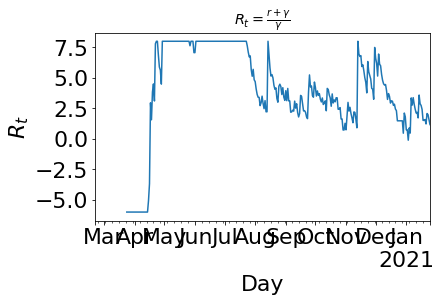

In [92]:
df["old_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_old-rt.png");

# Old $R_t$ with smoothed growth rate

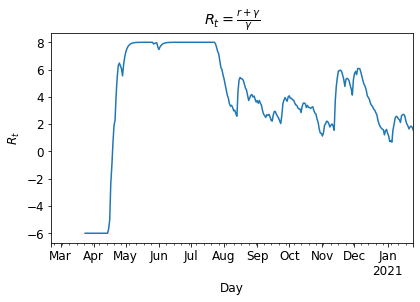

In [93]:
df["ewma_old_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_old-smooth-rt.png");

# New $R_t$ with unsmoothed growth rate

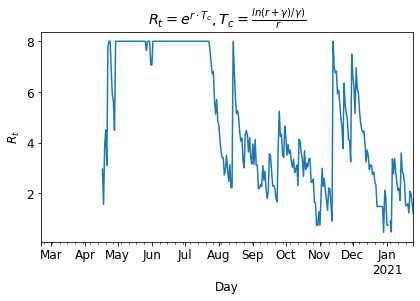

In [94]:
df["new_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = e^{r\cdot T_c}, T_c = \frac{ln(r + \gamma)/\gamma)}{r}$')
plt.savefig(f"{TODAY}_{FIPS}_new-rt.png");

# Smoothed new $R_t$

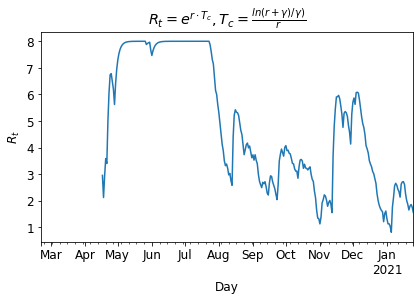

In [95]:
df["ewma_new_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = e^{r\cdot T_c}, T_c = \frac{ln(r + \gamma)/\gamma)}{r}$')
plt.savefig(f"{TODAY}_{FIPS}_new-smooth-rt.png");

In [96]:
df.loc[df["old_rt"] < 0, "nz_old_rt"] = np.nan
df.loc[df["ewma_old_rt"] < 0, "nz_ewma_old_rt"] = np.nan
# df["old_smooth_rt"] = df["old_smooth_rt"].rolling(window=7, min_periods=1).mean()
# df["old_rt"] = df["old_rt"].rolling(window=7, min_periods=1).mean()

# Old $R_t$ with unsmoothed growth rate and no negative values

In [97]:
df["nz_old_rt"].min()

0.46240116677344856

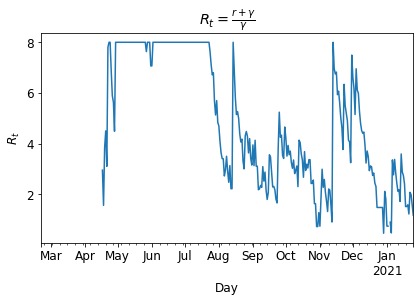

In [98]:
df["nz_old_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_old-rt.png");

# Old $R_t$ with smoothed growth rate and no negative values

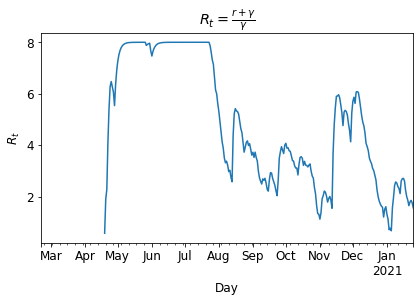

In [99]:
df["nz_ewma_old_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_old-smooth-rt.png");

In [100]:
df["nz_ewma_old_rt"] = df["ewma_old_rt"].fillna(df["ewma_new_rt"])
df["nz_old_rt"] = df["old_rt"].fillna(df["new_rt"])

# Old $R_t$ with unsmoothed growth rate and smooth new $R_t$ to replace negative values

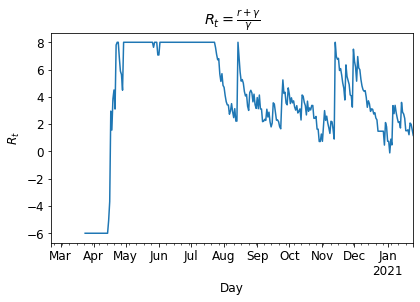

In [101]:
df["nz_old_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_old-rt.png");

# Old $R_t$ with smoothed growth rate and smooth new $R_t$ to replace negative values

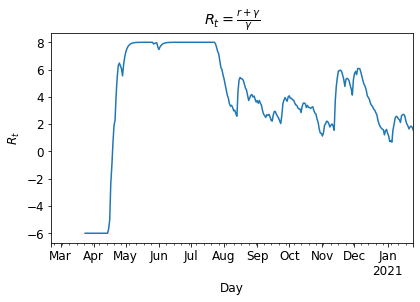

In [102]:
df["nz_ewma_old_rt"].plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'$R_t$')
plt.tight_layout()
plt.title(r'$R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_old-smooth-rt.png");

In [103]:
df.columns

Index(['countyFIPS', 'County Name', 'State', 'stateFIPS', 'confirmed', 'days',
       'new_cases', 'population', 'susceptible', 'gr', 'dt', 'beta', 'ewma_gr',
       'ma_gr', 'tc', 'clip_ewma_gr', 'new_rt', 'old_rt', 'ewma_new_rt',
       'ewma_old_rt', 'nz_old_rt', 'nz_ewma_old_rt'],
      dtype='object')

<AxesSubplot:>

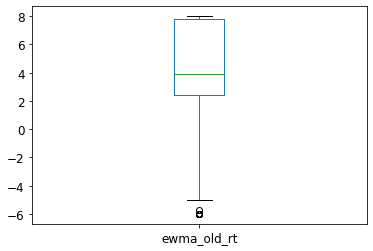

In [104]:
df.loc[df["days"] > 60, "ewma_old_rt"].plot.box()

In [105]:
global_max = round(df.loc[df["days"] > 60, "ewma_old_rt"].max(), 1)
global_min = round(df.loc[df["days"] > 60, "ewma_old_rt"].min(), 1)
global_75 = round(df.loc[df["days"] > 60, "ewma_old_rt"].quantile(.75), 1)
global_50 = round(df.loc[df["days"] > 60, "ewma_old_rt"].median(), 1)
global_25 = round(df.loc[df["days"] > 60, "ewma_old_rt"].quantile(.25), 1)

# Smoothed New versus Smoothed Old $R_t$

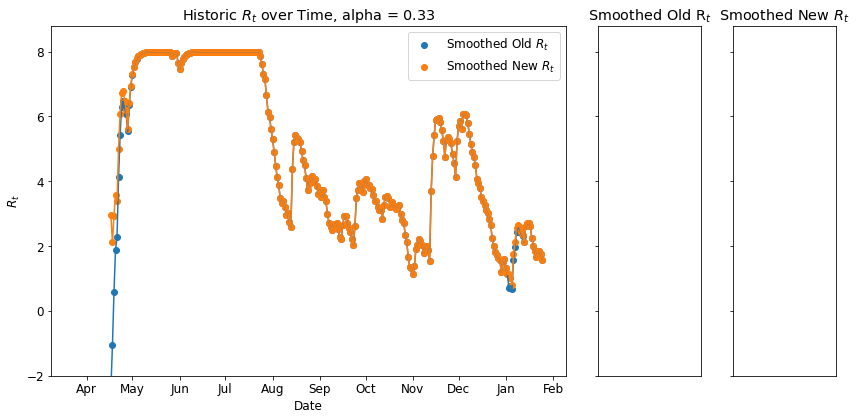

In [106]:
months = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6), gridspec_kw={"width_ratios": [5, 1, 1]})

ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(fmt)
ax1.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_old_rt"], label=r"Smoothed Old $R_t$")
ax1.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_old_rt"])
ax1.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_new_rt"], label=r"Smoothed New $R_t$")
ax1.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_new_rt"])

ax1.set_title(f"Historic $R_t$ over Time, alpha = {RT_EWMA_ALPHA:.2f}")
ax1.set_xlabel("Date")
ax1.set_ylabel(r"$R_t$")
ax1.legend()
plt.tight_layout()

ax2.boxplot(df.loc[df["days"] > 60, "ewma_old_rt"])
ax3.boxplot(df.loc[df["days"] > 60, "ewma_new_rt"])

ax2.set_ybound(0, global_max * 1.1)
ax2.set_xbound(.9, 1.1)
ax2.set_title(r"Smoothed Old R$_t$")
ax2.set_xticks([])

ax3.set_ybound(-2, global_max * 1.1)
ax3.set_xbound(.9, 1.1)
ax3.set_title(r"Smoothed New $R_t$")
ax3.set_xticks([]);

# New versus Old $R_t$

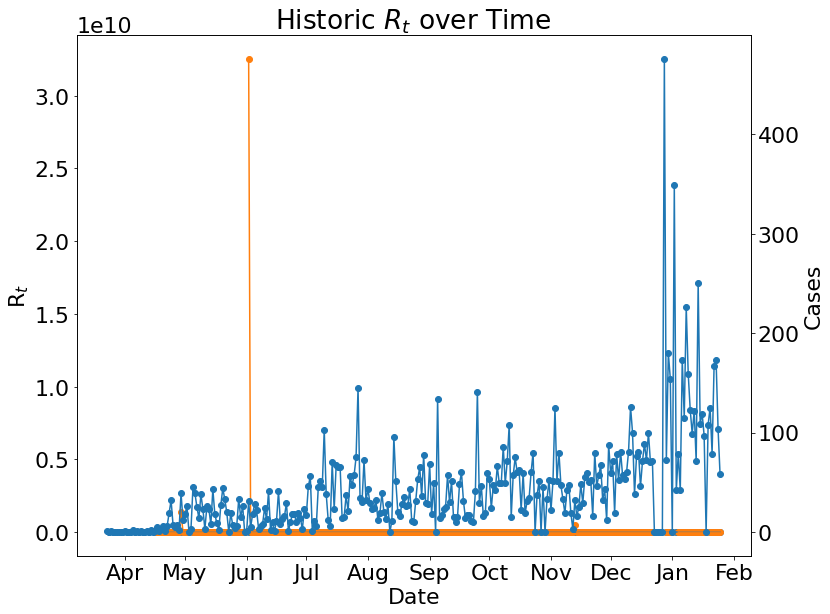

In [131]:
months = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "old_rt"], label=r"Old $R_t$")
ax.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "old_rt"])
ax.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_rt"], label=r"New $R_t$")
ax.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_rt"])
ax.set_xlabel("Date")
ax.set_ylabel(r"R$_t$")
ax2 = ax.twinx()
ax2.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_cases"], label=r"New cases")
ax2.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_cases"])
ax2.set_title(r"Historic $R_t$ over Time")
ax2.set_xlabel("Month")
ax2.set_ylabel(r"Cases")
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(fmt)
plt.tight_layout()

# Unsmoothed Old versus Smoothed Old $R_t$

In [108]:
plt.rcParams.update({'font.size': 22})

In [109]:
df.columns

Index(['countyFIPS', 'County Name', 'State', 'stateFIPS', 'confirmed', 'days',
       'new_cases', 'population', 'susceptible', 'gr', 'dt', 'beta', 'ewma_gr',
       'ma_gr', 'tc', 'clip_ewma_gr', 'new_rt', 'old_rt', 'ewma_new_rt',
       'ewma_old_rt', 'nz_old_rt', 'nz_ewma_old_rt'],
      dtype='object')

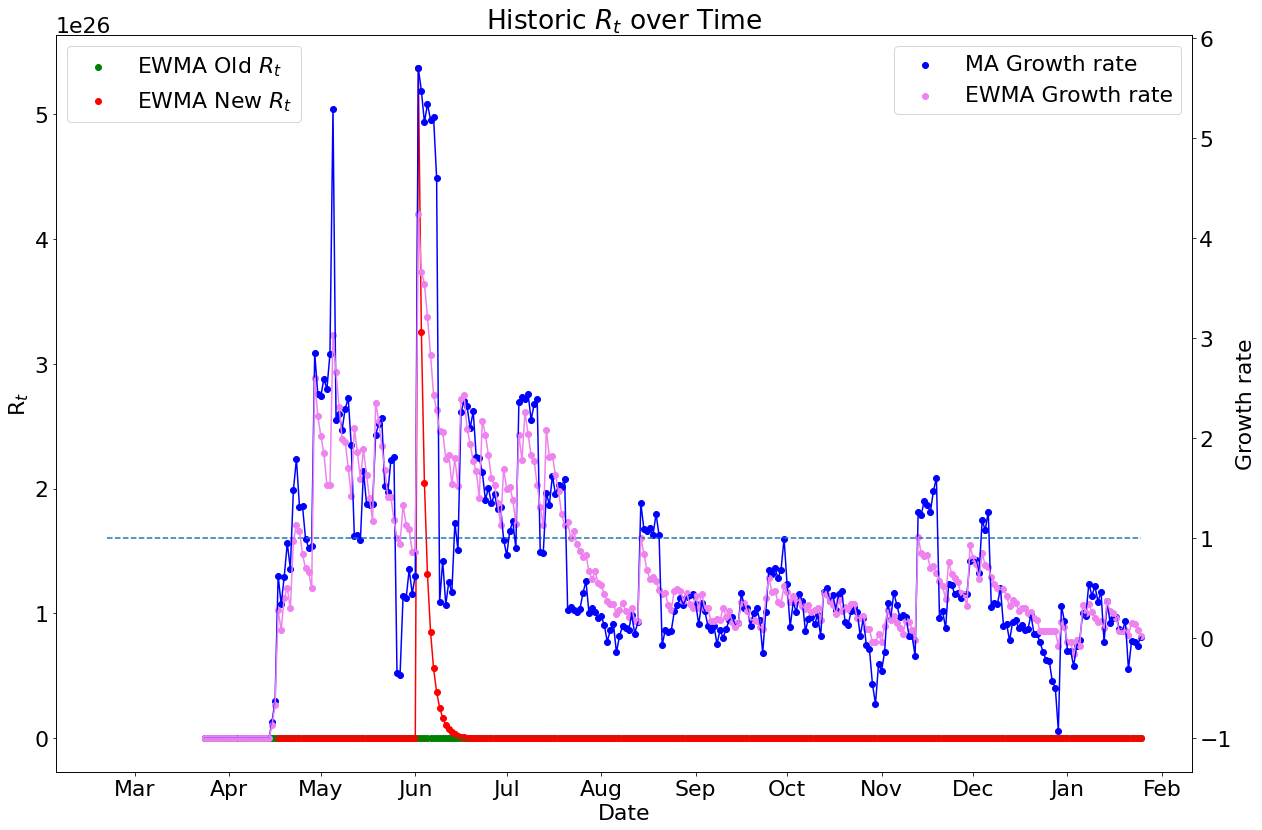

In [127]:
jk

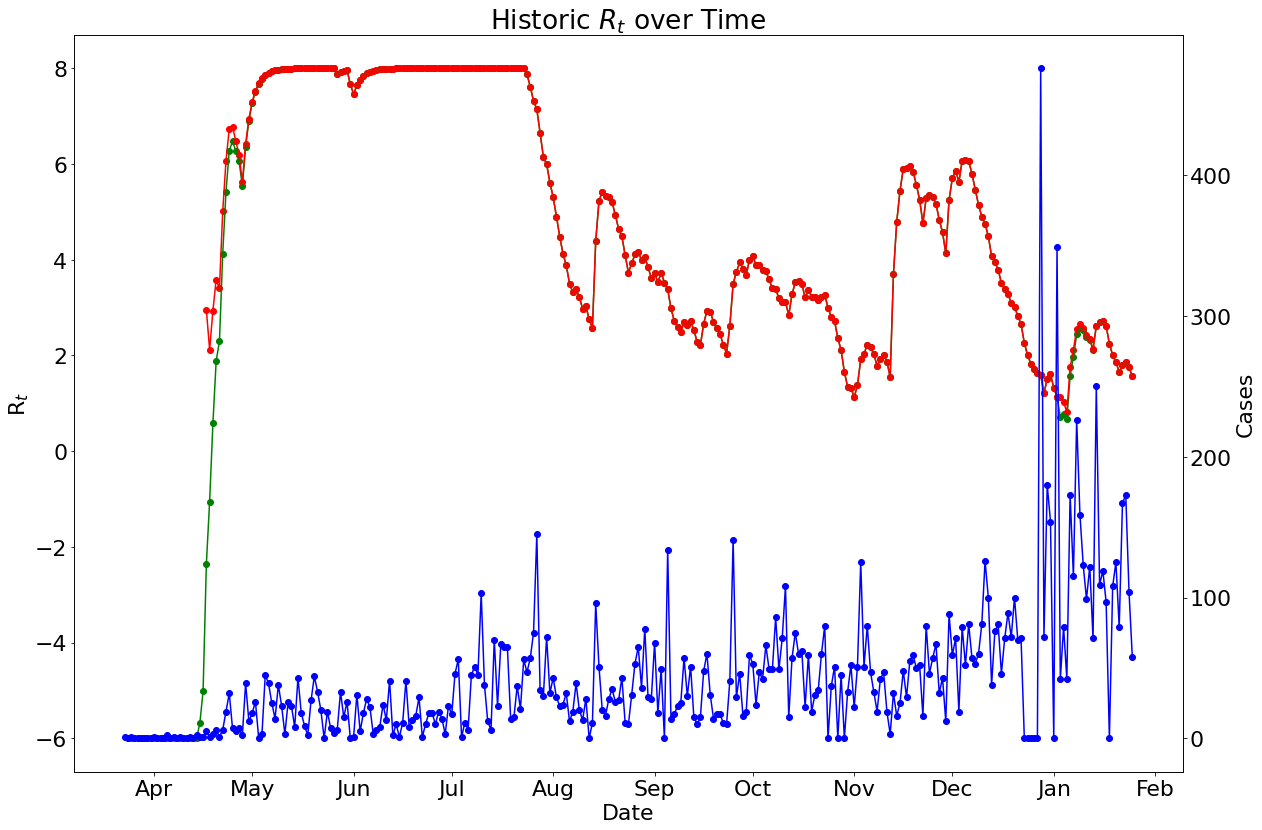

In [111]:
months = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots(figsize=(18,12))

ax.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_old_rt"], label=r"Old $R_t$", c='g')
ax.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_old_rt"], c='g')
ax.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_new_rt"], label=r"New $R_t$", c='r')
ax.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_new_rt"], c='r')
ax.set_xlabel("Date")
ax.set_ylabel(r"R$_t$")
ax2 = ax.twinx()
ax2.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_cases"], label=r"New cases", c='b')
ax2.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_cases"], c='b')
ax2.set_title(r"Historic $R_t$ over Time")
ax2.set_xlabel("Month")
ax2.set_ylabel(r"Cases")
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(fmt)

plt.tight_layout()

So I look at the image below and the estimate for Rt in the early period seem incredible high. The Rt is sustained above 6, but the disease does not take off and rocket, it just bounces around under 50 cases. There seems to be a fundamental flaw in the way we calculate Rt and until it is fixed we will have to scrap the entire feature!

If we have to censor all observations below 50 cases instead of 20 cases, fine, but this needs to pass the basic eye test.

Even then, when cases spiked in late January effective Rt plummeted!

Finally, the axis for Rt needs to be between the chart and the box and whisker, having it that far off to the right and away from the chart is not working in my opinion.

Please address.

Second, as I interact the forecast feature with the days until that Rt is applied there are some weird results. First the Rt is a straight line, where by definition we should show the current value projected for a certain number of days and then allow for a step function to the value entered. Meanwhile the forecast is broken, the first part seems correct in that it is a carry forward, then there is a straight line break until the second projection appears to kick in and I am unconvinced that second projection is at all proper given it needs to take the SIR content from staying the course before it can project what might happen under the new Rt.

![](charles.jpg)

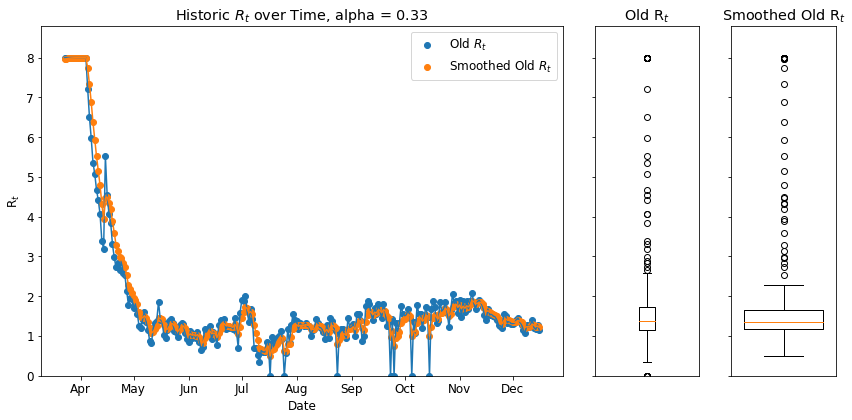

In [33]:
months = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6), gridspec_kw={"width_ratios": [5, 1, 1]})

ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(fmt)
ax1.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "old_rt"], label=r"Old $R_t$")
ax1.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "old_rt"])
ax1.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_old_rt"], label=r"Smoothed Old $R_t$")
ax1.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_old_rt"])
t = 't'
ax1.set_title(f"Historic $R_t$ over Time, alpha = {RT_EWMA_ALPHA:.2f}")
ax1.set_xlabel("Date")
ax1.set_ylabel(r"R$_t$")
ax1.legend()
plt.tight_layout()

ax2.boxplot(df.loc[df["days"] > 60, "old_rt"])
ax3.boxplot(df.loc[df["days"] > 60, "ewma_old_rt"])

ax2.set_title(r"Old R$_t$")
ax2.set_xticks([])

ax3.set_ybound(0, global_max * 1.1)
ax3.set_xbound(.9, 1.1)
ax3.set_title(r"Smoothed Old R$_t$")
ax3.set_xticks([]);

# Unsmoothed New versus Smoothed New $R_t$

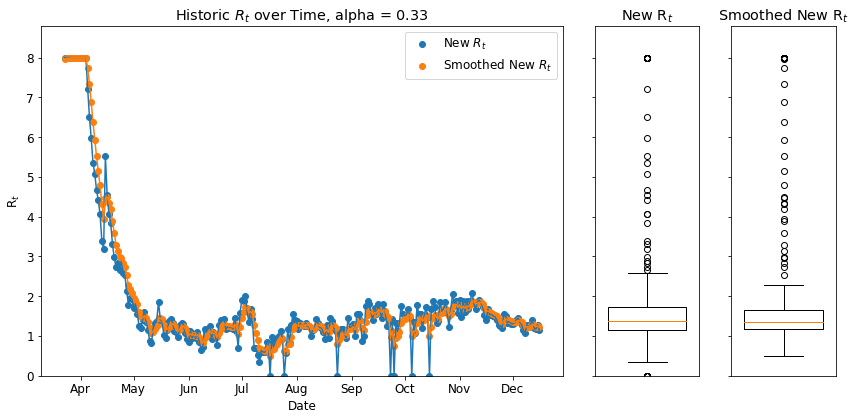

In [34]:
months = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 6), gridspec_kw={"width_ratios": [5, 1, 1]})

ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(fmt)
ax1.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_rt"], label=r"New $R_t$")
ax1.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "new_rt"])
ax1.scatter(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_new_rt"], label=r"Smoothed New $R_t$")
ax1.plot(df.loc[df["days"] > 60].index, df.loc[df["days"] > 60, "ewma_new_rt"])
t = 't'
ax1.set_title(f"Historic $R_t$ over Time, alpha = {RT_EWMA_ALPHA:.2f}")
ax1.set_xlabel("Date")
ax1.set_ylabel(r"R$_t$")
ax1.legend()
plt.tight_layout()

ax2.boxplot(df.loc[df["days"] > 60, "new_rt"])
ax3.boxplot(df.loc[df["days"] > 60, "ewma_new_rt"])

ax2.set_title(r"New R$_t$")
ax2.set_xbound(.9, 1.1)
ax2.set_xticks([])

ax3.set_ybound(0, global_max * 1.1)
ax3.set_xbound(.9, 1.1)
ax3.set_title(r"Smoothed New R$_t$")
ax3.set_xticks([]);